<a href="https://colab.research.google.com/github/shinchacoffee/MNIST_practice/blob/main/MNIST_ze_stronki_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision

In [ ]:
n_epochs = 3            # how many times data is used
batch_size_train = 64   # number of samples per one gradient calc
batch_size_test = 1000  # number of samples per one test step (used as many times as needed to empty the test set)
learning_rate = 0.01    # multiplicator (can be a vector) of gradient result (the higher the more impact each step has)
momentum = 0.5          # memory coefficient of dampening oscillations (1 is equal to infinite memory time and 0 to no memory at all)
log_interval = 10       # ??????? how frequently logs are produced ?

random_seed = 1         # seed do rng
torch.backends.cudnn.enabled = True # cause fuck TPU
torch.manual_seed(random_seed)      # giving seed to torch

In [ ]:
class asd:
  def __init__(self,x):
    self.x = x

  def __len__(self):
    return len(self.x)

  def __getitem__(self,idx):
    return self.x[idx]

y=asd(['asd1','asd2','asd3'])
print(y.x)
print(len(y))
print(y[1])

['asd1', 'asd2', 'asd3']
3
asd2


In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
for index, x in enumerate(train_loader):
  print(x[0][5].mean())
  print(index)
  break

for x in train_loader:
  print(x[0][5].mean())
  break
asd=enumerate(train_loader)

tensor(-0.1858)
0
tensor(-0.0542)


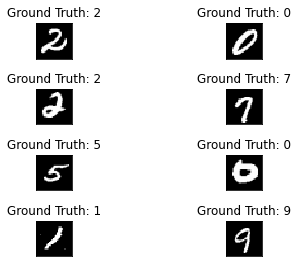

In [ ]:
import matplotlib.pyplot as plt

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(8):
  plt.subplot(4,2,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])


In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() #was super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  # ??? 28-5+1 dim times 10 versions out, 5*5*10 parameters
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # ??? 24+5-1 dim times 20 versions out, 5*5*20*10 parameters
        self.conv2_drop = nn.Dropout2d() # ??? 20 dim times 20 ver IN, 20 dim times 10 ver OUT
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [ ]:
network.to('cuda')

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data,target=data.to('cuda'),target.to('cuda')
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(network.state_dict(), '/results/model.pth')
      #torch.save(optimizer.state_dict(), '/results/optimizer.pth')


In [ ]:
for epoch in range(1, n_epochs + 1):
  train(epoch)

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data,target=data.to('cuda'),target.to('cuda')
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      ii=0
      for x,y,z in zip(pred.cpu().numpy(),target.cpu().numpy(),data.cpu().numpy()):
        if x != y:
          print(x[0],y,z.shape)
          plt.subplot(20,1,1+ii)
          plt.imshow(z[0], cmap='gray', interpolation='none')
          plt.title("truth: {} pred: {}".format(y,x))
          plt.xticks([])
          plt.yticks([])
          ii=ii+1
      break
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
test()
#for epoch in range(1, n_epochs + 1):
#  train(epoch)
#  test()

In [ ]:
import matplotlib.pyplot as plt

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(8):
  plt.subplot(4,2,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])